In [144]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score

In [146]:
#fix random seed for reproducibility
np.random.seed(42)

#parameters
ntraj_per_class = 200      # number of trajectories per class
trajlength = 40           # length of each trajectory
sigma = 0.4               # random noise strength
J_options = [             # drift directions for 3 classes
    np.array([0.2, 0.1]),
    np.array([-0.1, 0.2]),
    np.array([0.15, -0.15])
]
n_classes = len(J_options)
ntraj = ntraj_per_class * n_classes  # total number of trajectories

# true class label for each trajectory
traj_classes = np.repeat(np.arange(n_classes), ntraj_per_class)


In [148]:
# generate 2D trajectories
X = np.zeros((ntraj, trajlength, 2))
for i in range(ntraj):
    J = J_options[traj_classes[i]]
    for j in range(1, trajlength):
        # random walk with drift + Gaussian noise
        X[i, j] = X[i, j-1] + J + np.random.normal(0, sigma, size=2)

print("X shape:", X.shape)  # (ntraj, trajlength, 2)

# mapping 2D to 3D s-curve
Z = np.zeros((ntraj, trajlength, 3))
for i in range(ntraj):
    for j in range(trajlength):
        x_val = X[i, j, 0]
        y_val = X[i, j, 1]
        Z[i, j, 0] = np.sin(x_val / 2.0)                   
        Z[i, j, 1] = 2.0 * y_val                          
        Z[i, j, 2] = np.sign(x_val) * (np.cos(x_val / 2)-1)

print("Z shape:", Z.shape)  # (ntraj, trajlength, 3)

X shape: (600, 40, 2)
Z shape: (600, 40, 3)


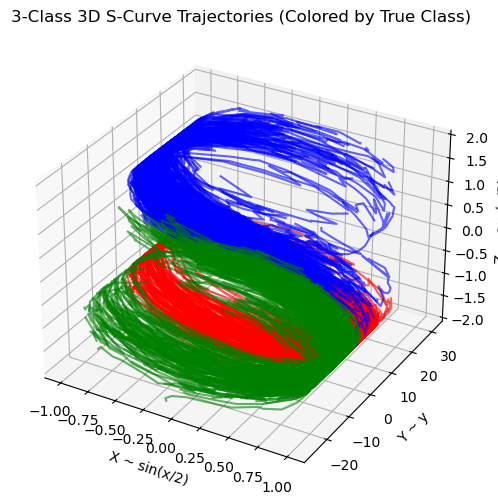

In [150]:
# visualize trajectories in 3D (true classes)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'blue', 'green']
for class_id in range(n_classes):
    idx = np.where(traj_classes == class_id)[0]
    for i in idx:
        ax.plot(Z[i,:,0], Z[i,:,1], Z[i,:,2], color=colors[class_id], alpha=0.6)

ax.set_title("3-Class 3D S-Curve Trajectories (Colored by True Class)")
ax.set_xlabel("X ~ sin(x/2)")
ax.set_ylabel("Y ~ y")
ax.set_zlabel("Z ~ cos(x/2)")
plt.show()


In [151]:
# Instead of using raw derivatives (which contain negative values),
# split the trajectory derivatives into positive and negative parts
# so that all features are non-negative and suitable for NMF.

traj_diff = np.diff(Z, axis=1)  # (n_traj, length-1, dim)

# Extract positive part of the derivatives
pos = np.clip(traj_diff, 0, None)      # values > 0 remain, others become 0

# Extract negative part of the derivatives (and make them positive)
neg = np.clip(-traj_diff, 0, None)     # values < 0 become positive magnitudes

# Flatten and concatenate both parts to form the final feature vector
traj_features = np.concatenate([
    pos.reshape(pos.shape[0], -1),
    neg.reshape(neg.shape[0], -1)
], axis=1)

print('Feature shape for clustering:', traj_features.shape)

Feature shape for clustering: (600, 234)


In [152]:
# unsupervised clustering evaluation
def evaluate_clustering(name, pred_labels):
    cm = confusion_matrix(traj_classes, pred_labels)
    nmi = normalized_mutual_info_score(traj_classes, pred_labels)
    print(f"\n {name} NMI: {nmi:.4f}")
    print(f"{name} Confusion Matrix:\n{cm}")
    
    # visualize confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel("Predicted Cluster")
    ax.set_ylabel("True Class")
    plt.colorbar(im, ax=ax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.show()

    # visualize trajectories colored by predicted cluster
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    cluster_colors = plt.cm.tab10(pred_labels.astype(float)/n_classes)
    for i in range(ntraj):
        ax.plot(Z[i,:,0], Z[i,:,1], Z[i,:,2], color=cluster_colors[i], alpha=0.4)
    ax.set_title(f"{name} Clusters in 3D")
    plt.show()
    


 KMeans NMI: 0.6027
KMeans Confusion Matrix:
[[ 64   2 134]
 [169   0  31]
 [  0 191   9]]


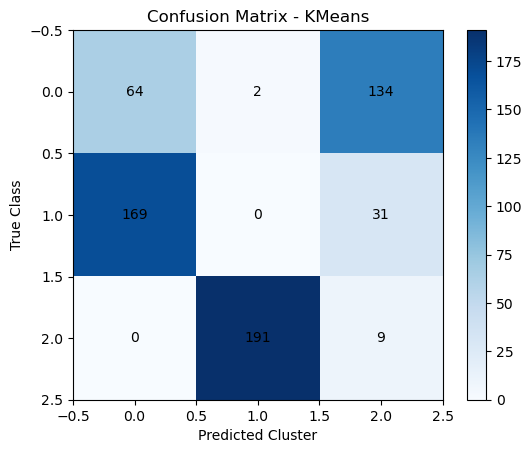

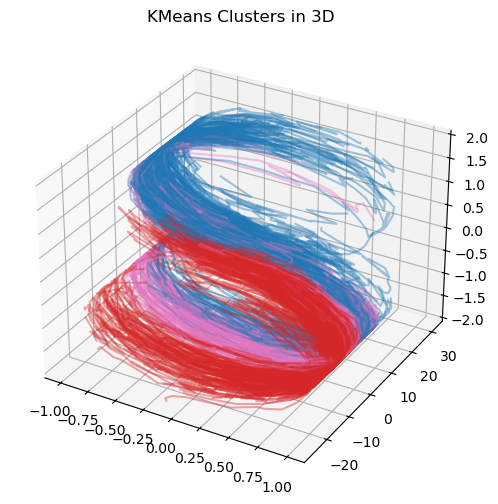

In [156]:
# KMeans
kmeans = KMeans(n_clusters=n_classes, random_state=42)
kmeans_labels = kmeans.fit_predict(traj_features)
evaluate_clustering("KMeans", kmeans_labels)


 Hierarchical NMI: 0.4406
Hierarchical Confusion Matrix:
[[108  23  69]
 [ 66   3 131]
 [  9 191   0]]


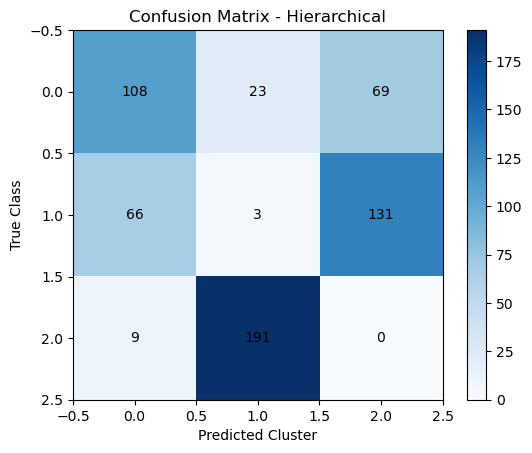

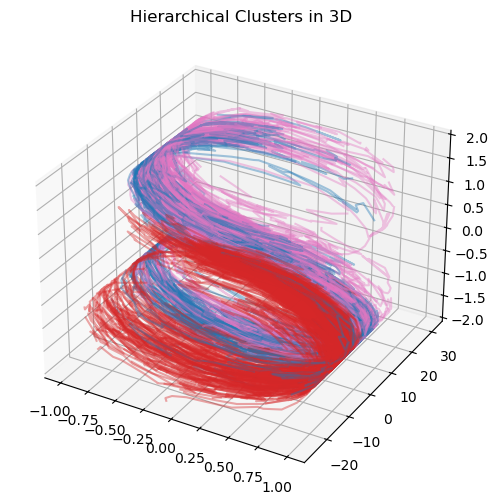

In [158]:
# hierarchical clustering 
agg = AgglomerativeClustering(n_clusters=n_classes)
agg_labels = agg.fit_predict(traj_features)
evaluate_clustering("Hierarchical", agg_labels)


 NMF NMI: 0.4801
NMF Confusion Matrix:
[[ 92  29  79]
 [134   0  66]
 [  0 199   1]]


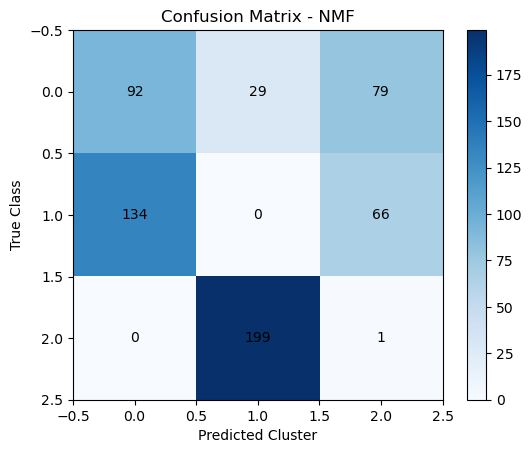

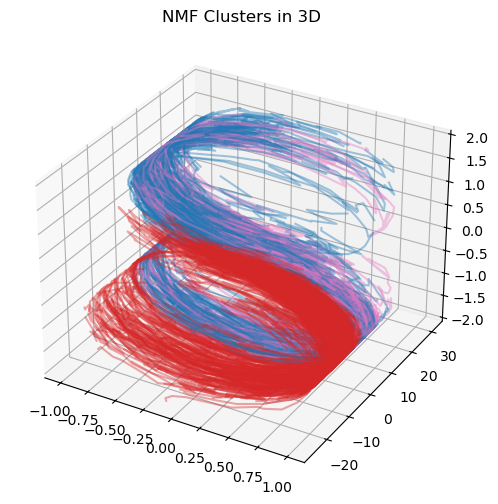

In [159]:
# NMF clustering
nmf_model = NMF(n_components=n_classes, init='random', random_state=42, max_iter=500)
nmf_W = nmf_model.fit_transform(np.abs(traj_features))  # ensure non-negative
nmf_labels = np.argmax(nmf_W, axis=1)
evaluate_clustering("NMF", nmf_labels)